In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense,ZeroPadding2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import datetime
from os import listdir 
from PIL import Image
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from matplotlib import pyplot as plt

In [6]:
X = np.load('/array/X.npy')

In [7]:
y = np.load('/array/y.npy')

In [8]:
ohe = OneHotEncoder(sparse=True)

In [9]:
y_ohe = ohe.fit_transform(y.reshape(-1,1)).toarray()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y_ohe)

In [14]:
checkpoint = ModelCheckpoint("/model/tasteria_model.h5", save_best_only=True)

In [15]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

In [16]:
log_dir = "/model/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [17]:

mbv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape = (160,160,3))
x = mbv2.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(15,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=mbv2.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


9420800/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [64]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 60, 60, 32)   864         ['input_10[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 60, 60, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 60, 60, 32)   0           ['bn_Conv1[0][0]']         

In [18]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs= 80 ,verbose=1, callbacks =[checkpoint, early_stop, tensorboard_callback])

Epoch 1/80
351/351 [==============================] - 56s 112ms/step - loss: 2.6232 - accuracy: 0.2129 - val_loss: 2.0472 - val_accuracy: 0.4385
Epoch 2/80
351/351 [==============================] - 37s 106ms/step - loss: 1.7889 - accuracy: 0.5088 - val_loss: 1.4861 - val_accuracy: 0.5957
Epoch 3/80
351/351 [==============================] - 37s 106ms/step - loss: 1.3447 - accuracy: 0.6441 - val_loss: 1.2314 - val_accuracy: 0.6652
Epoch 4/80
351/351 [==============================] - 37s 106ms/step - loss: 1.1200 - accuracy: 0.7038 - val_loss: 1.0745 - val_accuracy: 0.7128
Epoch 5/80
351/351 [==============================] - 37s 106ms/step - loss: 0.9726 - accuracy: 0.7434 - val_loss: 0.9776 - val_accuracy: 0.7401
Epoch 6/80
351/351 [==============================] - 37s 106ms/step - loss: 0.8652 - accuracy: 0.7767 - val_loss: 0.8912 - val_accuracy: 0.7682
Epoch 7/80
351/351 [==============================] - 37s 106ms/step - loss: 0.7821 - accuracy: 0.8049 - val_loss: 0.8358 - val_ac

In [19]:
model.save("/model/tasteria_model_fit.h5")

In [4]:
model  = tf.keras.models.load_model("/model/tasteria_model_fit.h5")

In [11]:
pred = model.predict(X_test)

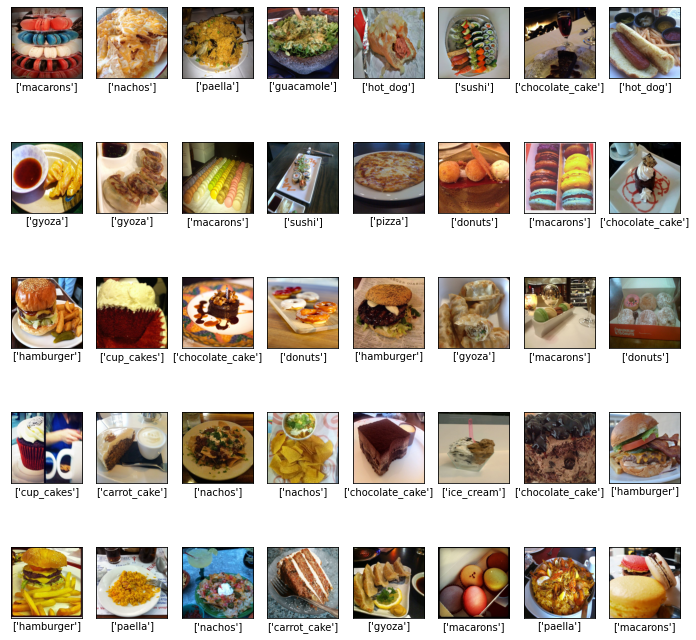

In [14]:
plt.figure(figsize=(12,12))
for i in range(40):
    plt.subplot(5,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i])
    plt.xlabel(ohe.inverse_transform(pred)[i])

In [19]:
X_val= []

for folder in "/val_data":
    images = listdir(f"/val_data")
    for image in images:
        if image == ".DS_Store":
            continue
        path = f"/val_data/{image}"
        size = (160,160)
        img = Image.open(path).resize(size).convert("RGB")
        img = np.array(img)
        img = img/255
        X_val.append(img)
X_val = np.array(X_val)

In [20]:
pred = model.predict(X_val)

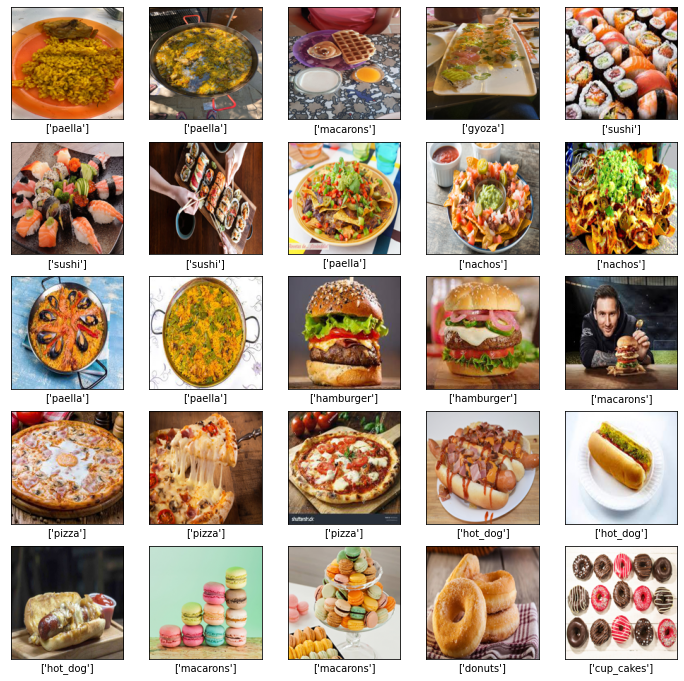

In [21]:
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_val[i])
    plt.xlabel(ohe.inverse_transform(pred)[i])